# Digit classifier with pytorch

## Settings

*%matplotlib inline* allows for plots inside the notebook.
Edge items for the print options for tensors are limited, which prints less information for tensors.
A manual seed is also set for pytorch.

In [88]:
%matplotlib inline
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

Training device is set, which is either the cpu (slower) or gpu (faster). *torch.cuda.is_available()* evaluates if a compatible gpu is available.

In [89]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print("Training device: {}".format(device))

Training device: cpu


## Prepare dataset

Datasets are downloaded into a new folder in the current directory, if not already found there. Samples are stored as tuples, where images are tensors and labels are integers. 

In [90]:
from torchvision import datasets
from torchvision import transforms
import os

data_path = data_path = os.getcwd() + '/dataset'

tensor_mnist = datasets.MNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
tensor_mnist_val = datasets.MNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

Information for the datasets and samples are presented. Note that the axes are needed to be changed from C × H × W to H × W × C to allow for plots. This is done with *permute*.

Number of samples in training set: 60000
Number of samples in validation set: 10000
Sample shape: torch.Size([1, 28, 28])
Pixel data type: torch.float32
Minimum pixel value: 0.0
Maximum pixel value: 1.0

Example with label = 5:


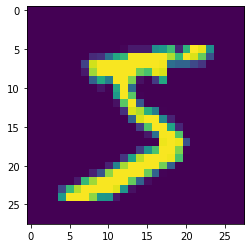

In [91]:
import matplotlib.pyplot as plt

img_t, label = tensor_mnist[0]

print("Number of samples in training set: {}".format(len(tensor_mnist)),
      "Number of samples in validation set: {}".format(len(tensor_mnist_val)),
      "Sample shape: {}".format(img_t.shape),
      "Pixel data type: {}".format(img_t.dtype),
      "Minimum pixel value: {}".format(img_t.min()),
      "Maximum pixel value: {}".format(img_t.max()),
      sep = '\n')

print("\nExample with label = {}:".format(label))
# Axes are changed from C × H × W to H × W × C to allow for plots.
plt.imshow(img_t.permute(1, 2, 0)) 
plt.show()

Data is normalized to ease training further on. This is done as follows:
$$\tilde{x}^i_j = \frac{x^i_j - \mu_j}{\sigma_j}$$
, where $\tilde{x}^i_j$ is the normalized data from sample $i$ and feature $j$, $x^i_j$ the raw data from sample $i$ and feature $j$, $\mu_j$ the mean over all samples for feature $j$, and $\sigma_j$ the standard deviation over all sampltes for feature $j$.

The mean and standard deviation for all samples are computed by stacking them.

The stacked tensor is unrolled using *view*.

In [92]:
# Stack samples
imgs = torch.stack([img_t for img_t, _ in tensor_mnist], dim=3)
print("Stacked data: {}".format(imgs.shape))


# view(1, -1) keeps the first channel and merges all the remaining dimensions into one. 
# Our 1 × 28 × 28 x 60000 images are transformed into a 1 x (28*28*60000) tensor.
imgs_mean = imgs.view(1, -1).mean(dim=1)
imgs_std = imgs.view(1, -1).std(dim=1)

print("Mean of all pixels: {:0.4f}".format(imgs_mean[0]),
      "Standard deviation of all pixels: {:0.4f}".format(imgs_std[0]),
      sep = '\n')

Stacked data: torch.Size([1, 28, 28, 60000])
Mean of all pixels: 0.1307
Standard deviation of all pixels: 0.3081


Normalized datasets are fetched using the computed mean and standard deviation. 

Note that the validation set is normalized with the training set mean and standard deviation. This is because the model will be shaped by the training set. The validation set must therefore have the same data preproccessing, so that the model will recognize validation set samples.

In [93]:
normalized_mnist = datasets.MNIST(data_path, train=True, download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(imgs_mean, imgs_std)]))

normalized_mnist_val = datasets.MNIST(data_path, train=False, download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(imgs_mean, imgs_std)]))

The datasets are prepared for training and evaluation by being put in data loaders. This makes the data compatible with forward- and backpropagation methods. 

The data is also divided into batches. This is made because the training set is very large, and using the whole dataset for forward- and backpropagation would be very computationally expensive.

In [94]:
batch_size = 16

val_loader = torch.utils.data.DataLoader(normalized_mnist_val, batch_size=batch_size, shuffle=False)

#for imgs_val, labels_val in val_loader:
#    print("Batch of validation images: {}".format(imgs_val.shape),
#          "Batch of validation labels: {}".format(labels_val.shape),
#          sep = "\n")
#    break

print(len(normalized_mnist))
help(normalized_mnist)
#train_subset = normalized_mnist_val[:10]


60000
Help on MNIST in module torchvision.datasets.mnist object:

class MNIST(torchvision.datasets.vision.VisionDataset)
 |  MNIST(*args, **kwds)
 |  
 |  `MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where ``MNIST/processed/training.pt``
 |          and  ``MNIST/processed/test.pt`` exist.
 |      train (bool, optional): If True, creates dataset from ``training.pt``,
 |          otherwise from ``test.pt``.
 |      download (bool, optional): If true, downloads the dataset from the internet and
 |          puts it in root directory. If dataset is already downloaded, it is not
 |          downloaded again.
 |      transform (callable, optional): A function/transform that  takes in an PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that takes in the
 |          target and transforms it.
 |  
 |  Method resolution

Large obsolete objects are deleted from memory.

In [95]:
del imgs
del tensor_mnist
del tensor_mnist_val

## Initialize model

A neural network is initialized with one hidden layer.

In [132]:
# Initialize linear neural network model with one hidden layer. 

import torch.nn as nn

hidden_features = 250

model = nn.Sequential(
    nn.Linear(784, hidden_features),
    nn.Sigmoid(),
    nn.Linear(hidden_features, 10),
    nn.LogSoftmax(dim=1))          # Converts output vector first to proabilities by
                                   # applying function torch.exp(x) / torch.exp(x).sum()
                                   # It then takes the log of this. We need the natural logarithmic
                                   # expression for the cost later on, and doing the 
                                   # calculation of ln in the model helps stability

In [108]:
# Shaping input data
# This is done by unrolling the 28x28 image into a 1D vector.
# Unrolling is done through "view", which changes the stride 
# of the contiguous linear container of numbers in memory.
# view(-1) changes the stride so that the resulting shape becomes
# torch.Size([a]), where "a" is "however many indexes are
# left, given the other dimensions and the original number of elements.”

img, label = normalized_mnist[0]
img_unrolled = img.view(-1).unsqueeze(0)    # Cost function requires the first dimension to be the batch, hence we need to add one dimension with unsqueeze 
label_tensor = torch.tensor([label])

print("Raw image shape: {}, Raw image stride: {}".format(img.shape, img.stride()),
     "Unrolled image shape: {}, Unrolled image stride: {}".format(img_unrolled.shape, img_unrolled.stride()),
     "Label tensor shape: {}".format(label_tensor.shape),
     sep = "\n")


Raw image shape: torch.Size([1, 28, 28]), Raw image stride: (1, 28, 1)
Unrolled image shape: torch.Size([1, 784]), Unrolled image stride: (784, 1)
Label tensor shape: torch.Size([1])


In [109]:
# Invoke model
import math

out = model(img_unrolled)    # natural logarithm of hypothesis probabilities from model 
out_probabilities = math.e ** out.detach()
largest_probability, predicted_label = torch.max(out_probabilities, dim=1)
print("Label: {}".format(label),
      "Output from model: {}".format(out),
      "Hypothesis probabilities from model: {}".format(out_probabilities),
      "The largest probability from the model is {:0.4f}, i.e. the predicted label is {}.".format(largest_probability[0], predicted_label[0]),
      sep = "\n")

Label: 5
Output from model: tensor([[-2.5628, -2.4362, -2.0545, -1.8584, -2.0896, -2.6426, -2.1723, -2.1898,
         -2.7706, -2.6892]], grad_fn=<LogSoftmaxBackward>)
Hypothesis probabilities from model: tensor([[0.0771, 0.0875, 0.1282, 0.1559, 0.1237, 0.0712, 0.1139, 0.1119, 0.0626,
         0.0679]])
The largest probability from the model is 0.1559, i.e. the predicted label is 3.


In [120]:
# Instatiate loss function
loss_fn = nn.NLLLoss()

In [111]:
# Calculate loss for test image
loss_fn(out, label_tensor) #Calculates sum(-out[label])

tensor(2.6426, grad_fn=<NllLossBackward>)

In [139]:
# Prepare training set sizes for learning curves
training_set_sizes = torch.tensor([1200, 2400, 6000, 20000, 30000, 40000, 50000, 60000])



trainset_1 = torch.utils.data.Subset(normalized_mnist, list(range(0, 16)))
print(len(trainset_1))

16


In [140]:
# Training loops
import torch.optim as optim
import timeit

n_epochs = 6
learning_rate = 1


set_size_loss_tensor_train = torch.zeros(len(training_set_sizes))
set_size_loss_tensor_val = torch.zeros(len(training_set_sizes))

optimizer.zero_grad()

for i, training_set_size in enumerate(training_set_sizes):
    tic1 = timeit.default_timer() #Take start time measurement

    train_subset = torch.utils.data.Subset(normalized_mnist, list(range(0, training_set_size)))
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    model.__init__ # Reinitialize model
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) #Prepare optimizer


    epoch_loss_tensor_train = torch.zeros(n_epochs)

    for epoch in range(n_epochs):
        tic2 = timeit.default_timer() #Take start time measurement
        
        batch_loss_sum_train = 0
        for imgs_train, labels_train in train_loader:
            imgs_train = imgs_train.to(device=device) #Move tensor to device 
            labels_train = labels_train.to(device=device) #Move tensor to device

            outputs_train = model(imgs_train.view(batch_size, -1)) #Unrolls images to a tensor with size [batch_size, 784]

            loss_train = loss_fn(outputs_train, labels_train)
            batch_loss_sum_train += loss_train.detach()             # detach removes gradient tracking

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        epoch_loss_tensor_train[epoch] = batch_loss_sum_train/len(train_loader)

        toc2 = timeit.default_timer() #Take stop time measurement

        print("Training set size: {}, Epoch: {}, Epoch time: {:0.1f} s, Average epoch training loss: {:0.4f}".format(training_set_size, epoch, toc2-tic2, float(epoch_loss_tensor_train[epoch])))

    
    
    # Forward propagation
    with torch.no_grad(): # Forward propagation does not accumulate gradients

        loss_sum_train = 0
        loss_sum_val = 0
        
        for imgs_train, labels_train in train_loader:
            imgs_train = imgs_train.to(device=device) #Move tensor to device 
            labels_train = labels_train.to(device=device) #Move tensor to device

            outputs_train = model(imgs_train.view(batch_size, -1))
            loss_sum_train += loss_fn(outputs_train, labels_train).detach()

        for imgs_val, labels_val in val_loader:
            imgs_val = imgs_val.to(device=device) #Move tensor to device 
            labels_val = labels_val.to(device=device) #Move tensor to device

            outputs_val = model(imgs_val.view(batch_size, -1))
            loss_sum_val += loss_fn(outputs_val, labels_val).detach()
    
    print("Loss_sum_train: {}, Train loader length: {}".format(loss_sum_train, len(train_loader)))
    print("Loss_sum_val: {}, Val loader length: {}".format(loss_sum_val, len(val_loader)))
    set_size_loss_tensor_train[i] = loss_sum_train/len(train_loader) # For plotting learning curves
    set_size_loss_tensor_val[i] = loss_sum_val/len(val_loader) # For plotting learning curves
    
    toc1 = timeit.default_timer() #Take start time measurement
    
    print("Model training complete. Training set size: {}, Training time: {:0.1f} s, Training set loss: {:0.4f}, Validation set loss: {:0.4f}".format(training_set_size, toc1-tic1, set_size_loss_tensor_train[i], set_size_loss_tensor_val[i]))


Training set size: 1200, Epoch: 0, Epoch time: 1.6 s, Average epoch training loss: 0.0060
Training set size: 1200, Epoch: 1, Epoch time: 1.2 s, Average epoch training loss: 0.0036
Training set size: 1200, Epoch: 2, Epoch time: 1.0 s, Average epoch training loss: 0.0030
Training set size: 1200, Epoch: 3, Epoch time: 1.0 s, Average epoch training loss: 0.0026
Training set size: 1200, Epoch: 4, Epoch time: 1.0 s, Average epoch training loss: 0.0023
Training set size: 1200, Epoch: 5, Epoch time: 1.0 s, Average epoch training loss: 0.0020
Loss_sum_train: 0.1387304961681366, Train loader length: 75
Loss_sum_val: 95.93080139160156, Val loader length: 625
Model training complete. Training set size: 1200, Training time: 15.3 s, Training set loss: 0.0018, Validation set loss: 0.1535
Training set size: 2400, Epoch: 0, Epoch time: 2.0 s, Average epoch training loss: 0.0047
Training set size: 2400, Epoch: 1, Epoch time: 2.0 s, Average epoch training loss: 0.0027
Training set size: 2400, Epoch: 2, E

KeyboardInterrupt: 

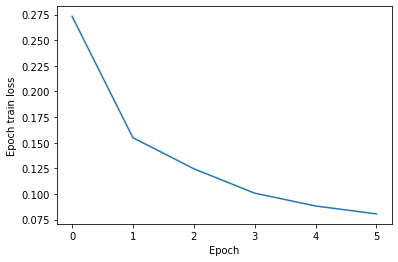

In [16]:
#Evaluate training

import numpy as np
import matplotlib.pyplot as plt

plt.plot(epoch_loss_tensor_train.numpy())
plt.xlabel('Epoch')
plt.ylabel('Epoch train loss')
plt.show()


In [17]:
#Evaluate model performance

loss_tensor_train = torch.zeros(len(train_loader))
correct_train = 0
total_train = len(normalized_mnist)

loss_tensor_val = torch.zeros(len(val_loader))
correct_val = 0
total_val = len(normalized_mnist_val)

with torch.no_grad(): # Forward propagation does not accumulate gradients
    
    for i, batch_train in enumerate(train_loader):
        imgs_train, labels_train = batch_train
        
        outputs_train = model(imgs_train.view(batch_size, -1))
        loss_train = loss_fn(outputs_train, labels_train)
        loss_tensor_train[i] = loss_train.detach()
        _, predicted_labels_train = torch.max(outputs_train, dim=1)
        correct_train += int((predicted_labels_train == labels_train).sum())
    
    for i, batch_val in enumerate(val_loader):
        imgs_val, labels_val = batch_val
        
        outputs_val = model(imgs_val.view(batch_size, -1))
        loss_val = loss_fn(outputs_val, labels_val)
        loss_tensor_val[i] = loss_val.detach()
        _, predicted_labels_val = torch.max(outputs_val, dim=1)
        correct_val += int((predicted_labels_val == labels_val).sum())
        
    

print("Training set accuracy: {:0.4f}".format(correct_train/total_train),
      "Training set cost: {:0.4f}".format(loss_tensor_train.mean(dim=0)),
      "Validation set accuracy: {:0.4f}".format(correct_val/total_val),
      "Validation set cost: {:0.4f}".format(loss_tensor_val.mean(dim=0)),
      sep = "\n")

Training set accuracy: 0.9781
Training set cost: 0.0672
Validation set accuracy: 0.9661
Validation set cost: 0.1154
